## Modeling : Predicting AQI - Ozone Arizona

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.decomposition import PCA
import pickle

In [2]:
# Load air data with power plant information
df = pd.read_csv('../data/ozone_pp_Arizona_mth_allpp_.csv') # yaer 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004

# Load vehicle data
df_rv = pd.read_csv('../data/registered_vehicles.csv')

In [3]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [4]:
df_rv['year'].unique()

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003], dtype=int64)

In [5]:
df['year'].unique()

array([2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004], dtype=int64)

In [6]:
df.shape

(1621557, 14)

In [7]:
# Drop rows of year 2018 as we don't have 2018 vehicle data
df.drop(df[df['year'] == 2018].index, axis=0, inplace=True)

In [8]:
df.shape

(1621557, 14)

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df = df.merge(df_rv, on=['state', 'year'], how='left')

In [11]:
df_air = df[df['air_type'] == 'ozone']
df_air['distance'].min(), df_air['distance'].max()

(0.4718028288546955, 4262.152577606613)

In [12]:
df_air.head(1)

,date,air_lat,air_long,air_type,aqi,pp_lat,pp_long,pp_boiler,fuel,distance,dir,state,year,month,automobile,bus,truck,motorcycle,all_mv
0,2016-01-01,37.179125,-113.305096,ozone,25.923077,32.1825,-110.863333,0.0,Sun,371.39111,SE,Arizona,2016,1,2377962,9016.0,3233330,166583.0,5786891.0


In [13]:
df_50 = df_air[['air_lat', 'air_long', 'distance']][df_air['distance'] <= 50]
df_100 = df_air[['air_lat', 'air_long', 'distance']][df_air['distance'] <= 100]
df_150 = df_air[['air_lat', 'air_long', 'distance']][df_air['distance'] <= 150]

In [14]:
df_50.drop_duplicates(inplace=True)
df_100.drop_duplicates(inplace=True)
df_150.drop_duplicates(inplace=True)

In [15]:
df_50 = df_50.pivot_table(index=['air_lat', 'air_long'], values=['distance'], aggfunc='count')
df_100 = df_100.pivot_table(index=['air_lat', 'air_long'], values=['distance'], aggfunc='count')
df_150 = df_150.pivot_table(index=['air_lat', 'air_long'], values=['distance'], aggfunc='count')

In [16]:
df_50.reset_index(level=['air_lat', 'air_long'], inplace=True)
df_100.reset_index(level=['air_lat', 'air_long'], inplace=True)
df_150.reset_index(level=['air_lat', 'air_long'], inplace=True)

In [17]:
df_50.rename(columns = {'distance':'num_pp_50_mi'}, inplace = True)
df_100.rename(columns = {'distance':'num_pp_100_mi'}, inplace = True)
df_150.rename(columns = {'distance':'num_pp_150_mi'}, inplace = True)

In [18]:
df_air = df_air.merge(df_50, on=['air_lat', 'air_long'], how='left')
df_air = df_air.merge(df_100, on=['air_lat', 'air_long'], how='left')
df_air = df_air.merge(df_150, on=['air_lat', 'air_long'], how='left')
df_air.head()

,date,air_lat,air_long,air_type,aqi,pp_lat,pp_long,pp_boiler,fuel,distance,dir,state,year,month,automobile,bus,truck,motorcycle,all_mv,num_pp_50_mi,num_pp_100_mi,num_pp_150_mi
0,2016-01-01,37.179125,-113.305096,ozone,25.923077,32.182500,-110.863333,0.0,Sun,371.391110,SE,Arizona,2016,1,2377962,9016.0,3233330,166583.0,5786891.0,23,46,99
1,2016-01-01,37.179125,-113.305096,ozone,25.923077,32.977400,-113.494500,0.0,Sun,289.849857,SW,Arizona,2016,1,2377962,9016.0,3233330,166583.0,5786891.0,23,46,99
2,2016-01-01,37.179125,-113.305096,ozone,25.923077,33.556100,-112.215300,3.0,Gas,257.233017,SE,Arizona,2016,1,2377962,9016.0,3233330,166583.0,5786891.0,23,46,99
3,2016-01-01,37.179125,-113.305096,ozone,25.923077,32.108147,-110.824662,0.0,Sun,376.987845,SE,Arizona,2016,1,2377962,9016.0,3233330,166583.0,5786891.0,23,46,99
4,2016-01-01,37.179125,-113.305096,ozone,25.923077,32.269000,-110.975000,0.0,Sun,363.481475,SE,Arizona,2016,1,2377962,9016.0,3233330,166583.0,5786891.0,23,46,99


In [19]:
df_air.isnull().sum()

date             0
air_lat          0
air_long         0
air_type         0
aqi              0
pp_lat           0
pp_long          0
pp_boiler        0
fuel             0
distance         0
dir              0
state            0
year             0
month            0
automobile       0
bus              0
truck            0
motorcycle       0
all_mv           0
num_pp_50_mi     0
num_pp_100_mi    0
num_pp_150_mi    0
dtype: int64

In [20]:
df_air.fillna(0, inplace=True)

In [21]:
df_air.isnull().sum()

date             0
air_lat          0
air_long         0
air_type         0
aqi              0
pp_lat           0
pp_long          0
pp_boiler        0
fuel             0
distance         0
dir              0
state            0
year             0
month            0
automobile       0
bus              0
truck            0
motorcycle       0
all_mv           0
num_pp_50_mi     0
num_pp_100_mi    0
num_pp_150_mi    0
dtype: int64

In [22]:
df_air.corr()[['aqi']].unstack().sort_values(kind="quicksort", ascending = False)

aqi  aqi              1.000000
     automobile       0.081376
     all_mv           0.034649
     pp_lat           0.033956
     pp_boiler        0.019802
     num_pp_50_mi     0.000669
     pp_long         -0.008908
     truck           -0.020112
     air_long        -0.025749
     air_lat         -0.027315
     distance        -0.032108
     motorcycle      -0.037972
     num_pp_100_mi   -0.040705
     month           -0.105911
     bus             -0.108406
     num_pp_150_mi   -0.109465
     year            -0.322246
dtype: float64

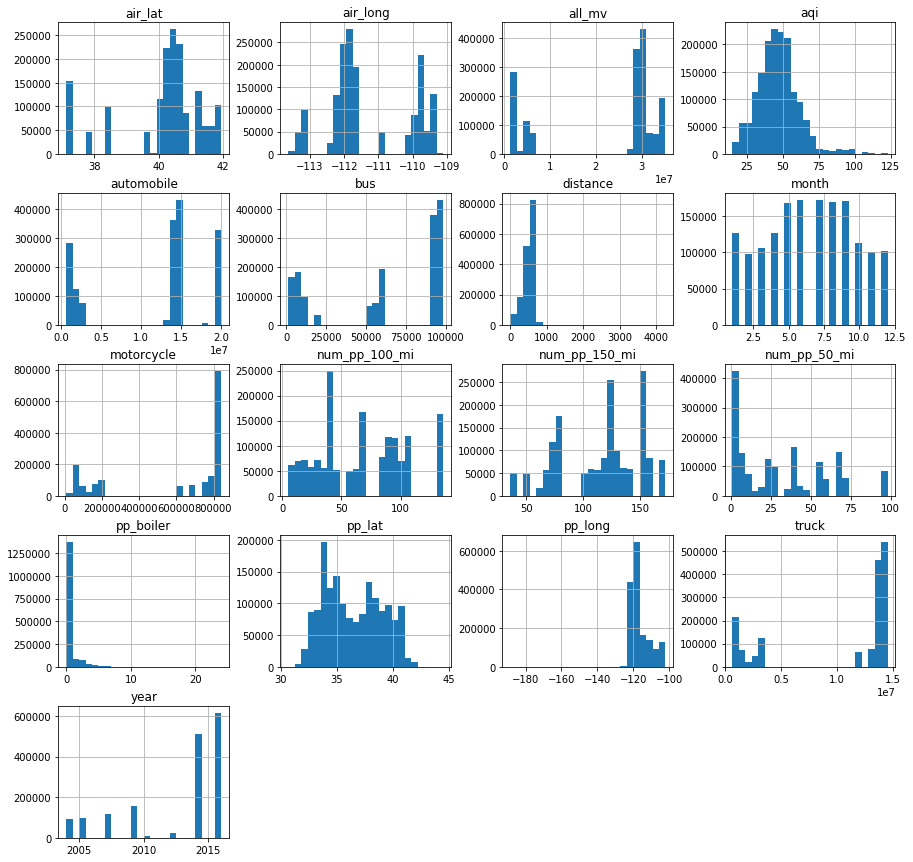

In [23]:
df_air.hist(figsize=(15,15), bins=24);

#### Preparing X and y

In [24]:
df_air.columns

Index(['date', 'air_lat', 'air_long', 'air_type', 'aqi', 'pp_lat', 'pp_long',
       'pp_boiler', 'fuel', 'distance', 'dir', 'state', 'year', 'month',
       'automobile', 'bus', 'truck', 'motorcycle', 'all_mv', 'num_pp_50_mi',
       'num_pp_100_mi', 'num_pp_150_mi'],
      dtype='object')

In [25]:
# 'date' column will be used only for timeseries modeling
X = df_air.drop(columns=['date', 'air_lat', 'air_long', 'air_type', 'aqi'], axis=1)
y = df_air['aqi']

In [26]:
simul = X.copy()

In [27]:
X = X.drop(columns=['pp_lat', 'pp_long'], axis=1)
X = pd.get_dummies(X, columns=['fuel', 'dir', 'month', 'state'], drop_first=True)

In [28]:
X.head(1)

,pp_boiler,distance,year,automobile,bus,truck,motorcycle,all_mv,num_pp_50_mi,num_pp_100_mi,num_pp_150_mi,fuel_Fossil_fuel,fuel_Gas,fuel_Hydro,fuel_Nuclear,fuel_Oil,fuel_Sun,fuel_Wind,dir_NW,dir_SE,dir_SW,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,state_California,state_Colorado,state_Nevada,state_New Mexico,state_Utah
0,0.0,371.39111,2016,2377962,9016.0,3233330,166583.0,5786891.0,23,46,99,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
X.columns

Index(['pp_boiler', 'distance', 'year', 'automobile', 'bus', 'truck',
       'motorcycle', 'all_mv', 'num_pp_50_mi', 'num_pp_100_mi',
       'num_pp_150_mi', 'fuel_Fossil_fuel', 'fuel_Gas', 'fuel_Hydro',
       'fuel_Nuclear', 'fuel_Oil', 'fuel_Sun', 'fuel_Wind', 'dir_NW', 'dir_SE',
       'dir_SW', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'state_California', 'state_Colorado', 'state_Nevada',
       'state_New Mexico', 'state_Utah'],
      dtype='object')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1216167, 37), (405390, 37), (1216167,), (405390,))

In [32]:
sc = StandardScaler()

In [33]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#### Decision Tree Regressor

In [89]:
dt1 = DecisionTreeRegressor(max_depth=10,
                           min_samples_leaf=7,
                           min_samples_split=20,
                           random_state=42)
dt1.fit(X_train, y_train)
dt1.score(X_train, y_train), dt1.score(X_test, y_test)

(0.9009659293569807, 0.90186177582613)

In [90]:
dt2 = DecisionTreeRegressor(max_depth=20,
                           min_samples_leaf=10,
                           min_samples_split=3,
                           random_state=42)
dt2.fit(X_train, y_train)
dt2.score(X_train, y_train), dt2.score(X_test, y_test)

(0.9998205259084376, 0.9998171539806865)

In [34]:
dt3 = DecisionTreeRegressor(max_depth=20,
                           min_samples_leaf=20,
                           min_samples_split=3,
                           random_state=42)
dt3.fit(X_train, y_train)
dt3.score(X_train, y_train), dt3.score(X_test, y_test)

(0.9998205259084376, 0.9998171539806865)

#### RandomForestRegressor

In [35]:
rf1 = RandomForestRegressor(random_state=42, max_depth= 20, n_estimators= 100)
rf1.fit(X_train, y_train)
rf1.score(X_train, y_train), rf1.score(X_test, y_test)

(0.9998209339494756, 0.9998174591436612)

In [36]:
df_result = pd.DataFrame()
df_result['features'] = X_train.columns
df_result['importance'] = rf1.feature_importances_
df_imp = df_result.sort_values(by='importance', ascending=False)
df_imp.reset_index(drop=True, inplace = True)

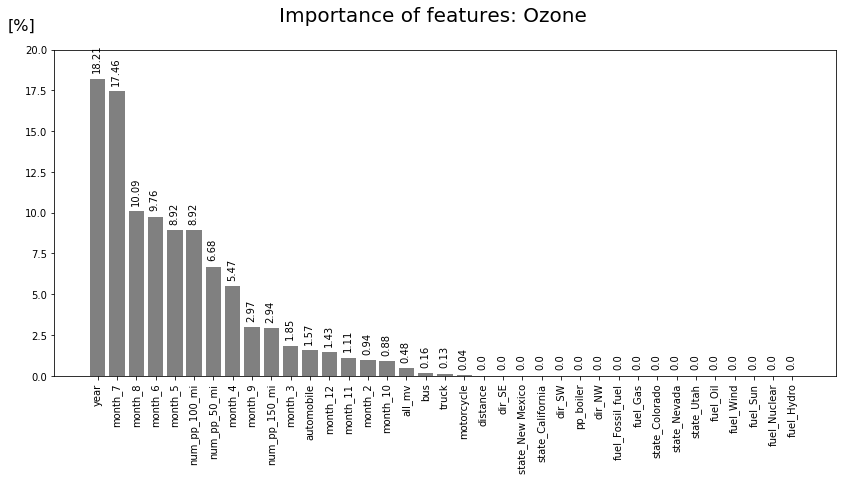

In [45]:
# Draw a barchart of performance of models
fig = plt.figure(figsize = (14, 6))
plt.bar(df_imp['features'], df_imp['importance'] * 100, color = 'gray')
plt.xticks(rotation=90)
plt.ylim(0, 20)

for width, height in enumerate(df_imp['importance']):
    plt.text(width-0.3, height * 100 + 0.5, round(height * 100, 2), rotation=90)

fig.suptitle('Importance of features: Ozone', fontsize=20)
# plt.xlabel('[Model]', fontsize=16, position=(0.95,100))
plt.ylabel('[%]', fontsize=16, rotation=0, position=(0,1.05))
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=12)
fig.savefig('../img/feature_importance_ozone_utah.png');

Pickle a model

In [43]:
model_fn = './pickles/rf_ozone_Arizona_dsi.pickle'

with open(model_fn, 'wb') as f:
    pickle.dump(rf1, f)

Load and test picked model

In [44]:
model_fn = './pickles/rf_ozone_Arizona_dsi.pickle'
    
with open(model_fn, 'rb') as f:
    mdl = pickle.load(f)

In [40]:
mdl.score(X_train, y_train), mdl.score(X_test, y_test)

(0.9998209339494756, 0.9998174591436612)

In [41]:
rf1.predict(X_test.head())

array([55.84946237, 46.3       , 60.25806452, 25.81111111, 44.61290323])

In [42]:
mdl.predict(X_test.head())

array([55.84946237, 46.3       , 60.25806452, 25.81111111, 44.61290323])

Make simulation files

In [36]:
X['fuel'] = simul['fuel']
X['state'] = simul['state']
X['lat'] = simul['pp_lat']
X['long'] = simul['pp_long']

In [37]:
X[X['distance'] <= 50].to_csv('../data/simul/rf_oz_Arizona_allpp_50.csv', index=False)
X[(X['distance'] > 50) & (X['distance'] <= 100)].to_csv('../data/simul/rf_oz_Arizona_allpp_100.csv', index=False)
X[(X['distance'] > 100) & (X['distance'] <= 150)].to_csv('../data/simul/rf_oz_Arizona_allpp_150.csv', index=False)

In [38]:
pd.DataFrame(columns=X_train.columns).to_csv('../data/simul/rf_oz_Arizona_allpp_columns.csv', index=False)